# Exploration 8: Text Summarization of News Articles

---

#### Model
* LSTM

#### Data
* News articles from [here](https://github.com/sunnysai12345/News_Summary)

#### Goals

1. Preprocessing the data including text normalization, vocabulary, stopwords, train test split, and more
2. Plot a graph to show convergence and create summarized sentences similar to the original summaries
3. Try both Extractive and Abstractive summarization and compare
---

## Importing Dependencies

In [4]:
import nltk
nltk.download('stopwords')

import os, re, time, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import warnings #to ignore warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import multiprocessing as mp # to reduce time
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences   
from multiprocessing import Pool
from functools import partial
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from summa.summarizer import summarize

print("All imported!")

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


All imported!


## Loading Data

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('number of total samples:', (len(data)))

number of total samples: 98401


In [5]:
data.sample(10)

,headlines,text
66023,HC refuses to lift bullock cart race ban in Ma...,The Bombay High Court on Wednesday refused to ...
93649,Video: KKR captain Gautam Gambhir's fumbling c...,Kolkata Knight Riders' captain Gautam Gambhir ...
89912,Which are the cheapest cities in the world for...,According to Deutsche Bank's report ranking th...
84932,"RIP TVs in Pakistan, tweets user on India-Pak ...",Reacting to India playing Pakistan in the fina...
3728,Police revokes ban on black at PM Modi event i...,Police in Jharkhand's Palamu has revoked the b...
96663,Dwayne Johnson chokes up in emotional video me...,Actor Dwayne Johnson choked up while sharing a...
95277,JNU ranked good not because of anti-India slog...,Union HRD Minister Prakash Javadekar on Monday...
41964,Russian Prez blames mall fire that killed 64 o...,Russian President Vladimir Putin has blamed th...
26406,Man takes selfie as 3 accident victims die in ...,A picture has surfaced online which shows a ma...
85869,I don't waste time gossiping or clicking selfi...,"Actress Shweta Basu Prasad, while talking abou..."


For Abstractive Summarization
* **headlines**: the summary
* **text**: the document <br/>

For Extractive Summarization only **text** will be used

---

## Data Pre-processing

### Remove duplicates and null values

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('number of total samples:', (len(data)))

number of total samples: 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


no null values yet

### Text normalization

#### Contractions

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("How many are there? There are", len(contractions) , "contractions.")

How many are there? There are 120 contractions.


#### Stopwords 

* most common words in any language like articles, prepositions, pronouns, conjuctions, etc.
* generally filtered out before processing a natural language b/c does not add much info to the text
* low-level information from the text can be removed to give more focus to the important information
* does not show any negative consequences on the model training


In [9]:
print('number of stopwords:', (len(stopwords.words('english'))))
print(stopwords.words('english'))

number of stopwords: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own'

words such as no, not, nor, most, up, down, again, but, below, and above seems somewhat useful for interpreting news article<br/>

In [10]:
excluded_words = ['no', 'not', 'nor', 'most', 'up', 'down', 'again', 'but', 'below', 'above']

adjusted_stopwords = list(filter(lambda word: word not in excluded_words, stopwords.words('english')))

In [11]:
print('number of adjusted stopwords:' , (len(adjusted_stopwords)))
print(adjusted_stopwords)

number of adjusted stopwords: 169
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'in', 'out', 'on', 'off', 'over', 'under', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'ju

#### Converting contractions, removing stopwords and other normalization

In [12]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # convert to lower case
    sentence = BeautifulSoup(sentence, "lxml").text # removing html tags
    sentence = re.sub(r'\([^)]*\)', '', sentence) # removing words in parentheses
    sentence = re.sub('"','', sentence) # removing quotation marks
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # converting contractions
    sentence = re.sub(r"'s\b","", sentence) # removing abbreviation Ex)roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # removing non alphabetic characters
    sentence = re.sub('[m]{2,}', 'mm', sentence) # removing too much 'm's Ex) ummmmmmm yeah -> umm yeah
   
    #removing stopwords for 'text'
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in adjusted_stopwords if len(word) > 1)
    # leaving all the stopwords for 'summary'
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('done')

done


In [13]:
temp_text = "ummmmmmm, ask Charlie or his pal (or his parents).<br/> Charlie's pal knows EVERYTHING!!!"
temp_summary = "We believe in you"

print("text:", preprocess_sentence(temp_text))
print("text:", preprocess_sentence(temp_summary, False)) # Not removing stopwords

text: umm ask charlie pal charlie pal knows everything
text: we believe in you


#### Using multiprocessing to make it faster

In [14]:
print(mp.cpu_count())

4


In [15]:
start = time.time()

def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # number of cores

    text_data_split = np.array_split(data, num_cores)  # parallel processing (by splitting data)
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # concatenate a sequence of arrays along an existing axis.
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False)
print(clean_summary)

16.75230598449707  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
print('total number of samples:', (len(data)))

total number of samples: 98360


#### Deciding the max length of input samples

text min length : 1
text max length : 60
text mean length : 35.61609394062627
summary min length : 1
summary max length : 16
summary mean length : 9.299532330215534


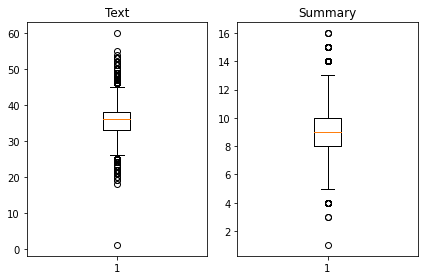

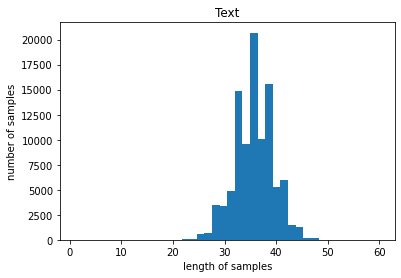

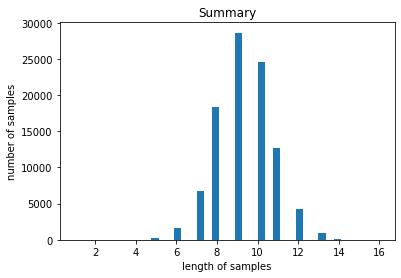

In [19]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('text min length : {}'.format(np.min(text_len)))
print('text max length : {}'.format(np.max(text_len)))
print('text mean length : {}'.format(np.mean(text_len)))
print('summary min length : {}'.format(np.min(summary_len)))
print('summary max length : {}'.format(np.max(summary_len)))
print('summary mean length : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 40
summary_max_len = 11

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('length of samples that are shorter than %s: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

length of samples that are shorter than 40: 0.9070963806425376
length of samples that are shorter than 11: 0.9449877999186661


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('total number of samples :', (len(data)))

total number of samples : 84303


#### Adding tokens

In [24]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [25]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

#### Splitting data

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[65963   948 21137 ... 44643 84281 28680]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('number of test data :', n_of_val)

number of test data : 16860


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('# of train data :', len(encoder_input_train))
print('# of train label :', len(decoder_input_train))
print('# of test data :', len(encoder_input_test))
print('# of test label :', len(decoder_input_test))

# of train data : 67443
# of train label : 67443
# of test data : 16860
# of test label : 16860


### Encoding

In [29]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [33]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # number of words
rare_cnt = 0 # number of words that appear less than the threshold
total_freq = 0 # total of words frequency in train data
rare_freq = 0 # the frequency of words that appear less than the threshold

# words and frequency in key-value pairs
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # if the word's frequency is less than the threshold
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('the size of vocabulary :', total_cnt)
print('number of words that appear less than %s times: %s'%(threshold - 1, rare_cnt))
print('adjusted size of vocabulary after removing rare words: %s'%(total_cnt - rare_cnt))
print("percentage of rare words in vocabulary:", (rare_cnt / total_cnt)*100)
print("percentage of rare words frequency in total frequency:", (rare_freq / total_freq)*100)

the size of vocabulary : 64129
number of words that appear less than 7 times: 45137
adjusted size of vocabulary after removing rare words: 18992
percentage of rare words in vocabulary: 70.38469335246145
percentage of rare words frequency in total frequency: 4.175860072161427


In [35]:
src_vocab = 18000 # adjusted size of vocabs after removing rare words
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # recreating vocabulary

In [36]:
# texts to sequences(numbers)
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[34, 252, 117, 2872, 360, 2361, 364, 440, 24, 118, 773, 1084, 124, 433, 1348, 2447, 1795, 334, 15226, 13471, 252, 11373, 2352, 85, 1084, 11, 102, 624], [1577, 1050, 704, 7935, 1, 1122, 41, 2, 3420, 390, 64, 5, 701, 43, 670, 522, 1139, 7080, 382, 498, 701, 3420, 1050, 1, 6393, 2779, 59, 1391, 1050, 3695, 1105], [2230, 12983, 516, 216, 282, 19, 127, 404, 516, 334, 7936, 39, 7936, 104, 1543, 3182, 496, 301, 1161, 997, 9946, 2477, 2, 592, 1363]]


do the same for the 'Summary'

In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

        
print('the size of vocabulary :', total_cnt)
print('number of words that appear less than %s times: %s'%(threshold - 1, rare_cnt))
print('adjusted size of vocabulary after removing rare words: %s'%(total_cnt - rare_cnt))
print("percentage of rare words in vocabulary:", (rare_cnt / total_cnt)*100)
print("percentage of rare words frequency in total frequency:", (rare_freq / total_freq)*100)

the size of vocabulary : 28268
number of words that appear less than 5 times: 18610
adjusted size of vocabulary after removing rare words: 9658
percentage of rare words in vocabulary: 65.83415876609594
percentage of rare words frequency in total frequency: 5.217782453446409


In [39]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# texts to sequences
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 36, 28, 219, 1185, 3, 828, 1228], [1, 921, 8, 33, 14, 7, 3444, 377, 989, 470, 116], [1, 5083, 737, 132, 385, 136, 5, 699, 8, 4864], [1, 1662, 2498, 5, 3936, 206], [1, 92, 244, 1066, 2550, 138, 8791, 8, 3004, 131, 5897]]
target
decoder  [[36, 28, 219, 1185, 3, 828, 1228, 2], [921, 8, 33, 14, 7, 3444, 377, 989, 470, 116, 2], [5083, 737, 132, 385, 136, 5, 699, 8, 4864, 2], [1662, 2498, 5, 3936, 206, 2], [92, 244, 1066, 2550, 138, 8791, 8, 3004, 131, 5897, 2]]


sostoken is converted to 1, eostoken to 2

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('# of dropped train data :', len(drop_train))
print('# of dropped test data :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('# of train data :', len(encoder_input_train))
print('# of train label :', len(decoder_input_train))
print('# of test data :', len(encoder_input_test))
print('# of test label :', len(decoder_input_test))

# of dropped train data : 0
# of dropped test data : 1
# of train data : 67443
# of train label : 67443
# of test data : 16859
# of test label : 16859


### Padding

In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('done')

done


## Model

In [43]:
# Encoder
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

# embedding layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [44]:
# Decoder
decoder_inputs = Input(shape=(None,))

# embedding layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [45]:
# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# model summary
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2304000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Attention mechanism

In [48]:
# attention layer
attn_layer = AdditiveAttention(name='attention_layer')

# deliver all the hidden state of decorder and encoder to the attention layer and return
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# connecting attention output with hidden state of decorder
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# decorder output
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# model summary
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2304000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## Compile and Fit

#### RMSprop
Using a decaying moving average of the partial derivative allows the search to forget early partial derivative values and focus on the most recently seen shape of the search space.

[RMSprop vs Adam](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)
>Simply put, RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter.<br/>
This means that the learning rate changes over time.

In [49]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
264/264 [==============================] - 157s 560ms/step - loss: 5.9451 - val_loss: 5.5321
Epoch 2/50
264/264 [==============================] - 148s 561ms/step - loss: 5.3825 - val_loss: 5.1581
Epoch 3/50
264/264 [==============================] - 150s 567ms/step - loss: 5.0431 - val_loss: 4.8986
Epoch 4/50
264/264 [==============================] - 147s 559ms/step - loss: 4.7651 - val_loss: 4.6937
Epoch 5/50
264/264 [==============================] - 146s 552ms/step - loss: 4.5469 - val_loss: 4.5402
Epoch 6/50
264/264 [==============================] - 145s 550ms/step - loss: 4.3691 - val_loss: 4.4162
Epoch 7/50
264/264 [==============================] - 146s 555ms/step - loss: 4.2112 - val_loss: 4.3205
Epoch 8/50
264/264 [==============================] - 145s 550ms/step - loss: 4.0720 - val_loss: 4.2305
Epoch 9/50
264/264 [==============================] - 146s 552ms/step - loss: 3.9502 - val_loss: 4.1819
Epoch 10/50
264/264 [==============================] - 146s 552m

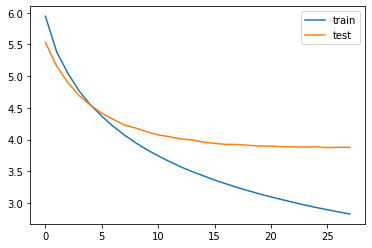

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Inference model

In [51]:
src_index_to_word = src_tokenizer.index_word 
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word 

In [52]:
# Encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [53]:
# attention function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# decoder output
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [54]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS> token
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  stop if reaches <eos> or the max length
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # target sequence update (length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # status update
        e_h, e_c = h, c

    return decoded_sentence

In [55]:
# sequence to text for text
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# sequence to text for headlines
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [57]:
for i in range(80, 100):
    print('number:', i)
    print("text :", seq2text(encoder_input_test[i]))
    print("original headlines :", seq2summary(decoder_input_test[i]))
    print("expected headlines :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

number: 80
text : warning citizens buying selling bitcoin turkey directorate religious affairs said cryptocurrency not accordance islam adding bitcoin not authorised state religious body said cryptocurrency widely used illegal activities not regulated 
original headlines : turkish religious authority declares bitcoin un islamic 
expected headlines :  bitcoin is not bitcoin says it is


number: 81
text : andhra pradesh cm chandrababu naidu monday alleged centre threatening impose president rule state nobody down threats added said rally similar kolkata united india rally held amaravati leaders parties take part 
original headlines : centre threatening to impose prez rule in andhra cm naidu 
expected headlines :  andhra cm calls for andhra cm over rohingyas


number: 82
text : samajwadi party chief akhilesh yadav tuesday said cannot anyone politics ready make alliances parties take bjp polls idea defeat bjp lines candidates contest symbol parties added nn 
original headlines : cannot any

#### So far
number 85 seems quite right <br/>
the loss was too high and needs to be adjusted <br/>
could try adjusting hyperparmeters, reducing the size of vocabulary or using different optimizer

## Using Summa for Extractive Summarization

In [5]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('number of total samples:', (len(data2)))

number of total samples: 98401


In [6]:
data2 = data2[['text', 'headlines']]
data2.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

In [7]:
print('Summary:')
print(summarize(data2['Text'].apply(str).iloc[1], ratio=0.4))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [8]:
data2['Text'].apply(str).iloc[1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

In [86]:
# using 'words'
for idx, text in enumerate(data2['Text'][:10]):
    print(f'<Text_{idx+1}> \n{text}\n')
    print(f'<Summary> \n{summarize(text, words=20)}\n\n')

<Text_1> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

<Summary> 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


<Text_2> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

<Summary> 
Users get one CRED coin per rupee of b

In [83]:
# using 'ratio'
def summarized_news(idx):
    for i in idx:
        print(f"<Text_{i+1}> \n{data2['Text'].apply(str).iloc[i]} \n")
        print('<Summary>\n', summarize(data2['Text'].apply(str).iloc[i], ratio=0.5), '\n\n')

In [84]:
summarized_news([0, 2, 5])

<Text_1> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers. 

<Summary>
 upGrad's Online Power Learning has powered 3 lakh+ careers. 


<Text_3> 
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history. 

<Summary>
 The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history. 


<Text_6> 
Pakistani singer Rahat Fateh Ali Khan ha

---

## Conclusion

### Abstractive vs Extractive summarization

#### Abstractive summarization:

**#80 Good: found 'what' Bad: missing 'who' and the main topic** <br/>
Influenced by: a specific country related article, religious words <br/>

**text:** warning citizens buying selling bitcoin turkey directorate religious affairs said cryptocurrency not accordance islam adding bitcoin not authorised state religious body said cryptocurrency widely used illegal activities not regulated <br/>
**original headlines:** turkish religious authority declares bitcoin un islamic <br/>
**expected headlines:** bitcoin is not bitcoin says it is<br/>

**#92 Good: found 'who'  Bad: repeated words, missing 'what'** <br/>
Influenced by: technical terms <br/>

**text:** china based scientists discovered method convert tree leaves carbon material used make electronics  dried phoenix tree leaves grounded heated produced powder carbon heating chemical treatment powder developed charge holding capacity three times graphene researchers said <br/>
**original headlines:** scientists convert tree leaves into electronics <br/>
**expected headlines:** scientists study study <br/>

#### Extractive summarization:

**Text_1** <br/>
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.<br/>

**Summary** <br/>
**using `words=20`**<br/>
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.<br/>
upGrad's Online Power Learning has powered 3 lakh+ careers.<br/> 

**using `ratio=0.5`**<br/>
upGrad's Online Power Learning has powered 3 lakh+ careers.<br/> 


**Text_3** <br/>
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.<br/> 

**Summary** <br/>
**using `words=20`**<br/> 
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.<br/> 

**using `ratio=0.5`**<br/>
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.<br/> 

can see that `words` or `ratio` does not make any difference <br/>

After trying both of them, short sentences or paragraphs fit better with Extractive summarization while long articles would suit better with Abstractive summarization.<br/>
Although the accuracy of abstractive summarization must be high enough to deliver an understandable message, it would make more sense to understand the whole article or paper and create an estimated summary rather than just popping a few words out of the context.<br/>
However, for short sentences, choosing words from the text will increase comprehension because it's less likely to choose the rare or unimportant words.<br/>

### Attention Mechanism

This [article](https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/) was helpful to understand what Attention Mechanism is.<br/>
To briefly explain, it helps to choose features that need to be focused on or ignored.<br/>
definitely something to remember b/c it is widely used in NLP and even in CV.<br/>

Even after applying the attention function, the accuracy was very low. <br/>
As stated before, adjusting hyperparameters, reducing the size of vocabulary, or using different optimizers might increase the accuracy.<br/>

Still somewhat disappointed with the result and definitely will work on it more later.